In [13]:
%matplotlib inline

import numpy as np
import pandas as pd

import tensorflow as tf
from tensorflow import keras


from skimage.io import imread
from skimage.transform import resize, rotate
from skimage.color import rgb2gray

from sklearn.model_selection import train_test_split

import os
import matplotlib.pyplot as plt

from tqdm.notebook import tqdm

# Reading data

In [25]:
def read_and_resize_dataset(dataset_dir, gt_path, size=(100, 100, 1)):
    gt = pd.read_csv(gt_path)
    files = sorted(os.listdir(dataset_dir))
    images = []
    keypoints_data = []
    for i in tqdm(range(len(files)), desc='reading images...'):
        img = imread(dataset_dir+'/'+files[i])
        x, y = img.shape[0], img.shape[1]
        img = rgb2gray(img)
        img = resize(img, size, mode='constant')

        keypoints = gt.iloc[i, 1:].values
        xs = keypoints[::2].astype('float32')
        ys = keypoints[1::2].astype('float32')
        xs = np.rint(xs / x * size[0])
        ys = np.rint(ys / y * size[1])
        keypoints[::2] = xs
        keypoints[1::2] = ys

        keypoints_data.append(keypoints)
        images.append(img)
    images = np.array(images, dtype='float32')
    keypoints_data = np.array(keypoints_data)
    return images, keypoints_data

# Augmentations

In [26]:
def mirror(img, keypoints):
    new_img = np.zeros((100, 100, 1))
    new_img[:, :, 0] = np.fliplr(img[:, :, 0])
    xs = keypoints[::2]
    xs = 100 - xs
    ys = keypoints[1::2]
    
    new_key = np.zeros_like(keypoints)
    
    new_key[0] = xs[3]
    new_key[1] = ys[3]
    
    new_key[2] = xs[2]
    new_key[3] = ys[2]
    
    new_key[4] = xs[1]
    new_key[5] = ys[1]
    
    new_key[6] = xs[0]
    new_key[7] = ys[0]
    
    new_key[8] = xs[9]
    new_key[9] = ys[9]
    
    new_key[10] = xs[8]
    new_key[11] = ys[8]
    
    new_key[12] = xs[7]
    new_key[13] = ys[7]
    
    new_key[14] = xs[6]
    new_key[15] = ys[6]
    
    new_key[16] = xs[5]
    new_key[17] = ys[5]
    
    new_key[18] = xs[4]
    new_key[19] = ys[4]
    
    new_key[20] = xs[10]
    new_key[21] = ys[10]
    
    new_key[22] = xs[13]
    new_key[23] = ys[13]
    
    new_key[24] = xs[12]
    new_key[25] = ys[12]
    
    new_key[26] = xs[11]
    new_key[27] = ys[11]
        

    return new_img, new_key

In [27]:
def rotation(image,facekeys, ang_pos):
    a=ang_pos*np.pi/180
    rot_matrix=np.array([[np.cos(a),np.sin(a)],[-np.sin(a),np.cos(a)]])
    facekeys_r=np.array(facekeys.reshape(14, 2))
    img=rotate(image,ang_pos,center=(0,0),mode='constant',resize=False,order=1)
    for i in range(0,14):

        facekeys_r[i]=np.dot(rot_matrix,facekeys_r[i].T)

    return img, facekeys_r.ravel()

In [28]:
def augmentation(x, y):
    new_x, new_y = np.zeros_like(x), np.zeros_like(y)
    r = x.shape[0]
    for i in tqdm(range(r), leave=False):
        x_m, y_m = mirror(x[i], y[i])
        new_x[i] = x_m
        new_y[i] = y_m
    ex = np.vstack((x, new_x))
    ey = np.vstack((y, new_y))
    r = ex.shape[0]
    angles = [np.random.rand() * 10 - 15, np.random.rand() * 10 + 5]
    for ang in tqdm([-15, 15], leave=False):
        new_x, new_y = np.zeros((r, 100, 100, 1)), np.zeros((r, 28))

        for i in tqdm(range(r), leave=False):
            x_m, y_m = rotation(ex[i], ey[i], ang)
            new_x[i] = x_m
            new_y[i] = y_m
        ex = np.vstack((ex, new_x))
        ey = np.vstack((ey, new_y))
    return ex, ey

# Model

In [90]:
# Kaggle
from keras.layers.advanced_activations import LeakyReLU
from keras.models import Sequential, Model
from keras.layers import Activation, Convolution2D, MaxPooling2D, BatchNormalization, Flatten, Dense, Dropout, Conv2D,MaxPool2D, ZeroPadding2D


model = Sequential()

model.add(Convolution2D(32, (3,3), padding='same', use_bias=False, input_shape=(100,100,1)))
model.add(LeakyReLU(alpha = 0.1))
model.add(BatchNormalization())

model.add(Convolution2D(32, (3,3), padding='same', use_bias=False, input_shape=(100,100,1)))
model.add(LeakyReLU(alpha = 0.1))
model.add(BatchNormalization())
model.add(MaxPool2D(pool_size=(2, 2)))

model.add(Convolution2D(64, (3,3), padding='same', use_bias=False))
model.add(LeakyReLU(alpha = 0.1))
model.add(BatchNormalization())

model.add(Convolution2D(64, (3,3), padding='same', use_bias=False))
model.add(LeakyReLU(alpha = 0.1))
model.add(BatchNormalization())
model.add(MaxPool2D(pool_size=(2, 2)))

model.add(Convolution2D(96, (3,3), padding='same', use_bias=False))
model.add(LeakyReLU(alpha = 0.1))
model.add(BatchNormalization())

model.add(Convolution2D(96, (3,3), padding='same', use_bias=False))
model.add(LeakyReLU(alpha = 0.1))
model.add(BatchNormalization())
model.add(MaxPool2D(pool_size=(2, 2)))

model.add(Convolution2D(128, (3,3),padding='same', use_bias=False))
model.add(LeakyReLU(alpha = 0.1))
model.add(BatchNormalization())

model.add(Convolution2D(128, (3,3),padding='same', use_bias=False))
model.add(LeakyReLU(alpha = 0.1))
model.add(BatchNormalization())
model.add(MaxPool2D(pool_size=(2, 2)))

model.add(Convolution2D(256, (3,3),padding='same',use_bias=False))
model.add(LeakyReLU(alpha = 0.1))
model.add(BatchNormalization())

model.add(Convolution2D(256, (3,3),padding='same',use_bias=False))
model.add(LeakyReLU(alpha = 0.1))
model.add(BatchNormalization())
model.add(MaxPool2D(pool_size=(2, 2)))

model.add(Convolution2D(512, (3,3), padding='same', use_bias=False))
model.add(LeakyReLU(alpha = 0.1))
model.add(BatchNormalization())

model.add(Convolution2D(512, (3,3), padding='same', use_bias=False))
model.add(LeakyReLU(alpha = 0.1))
model.add(BatchNormalization())


model.add(Flatten())
model.add(Dense(512,activation='relu'))
model.add(Dropout(0.1))
model.add(Dense(28))
model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_73 (Conv2D)           (None, 100, 100, 32)      288       
_________________________________________________________________
leaky_re_lu (LeakyReLU)      (None, 100, 100, 32)      0         
_________________________________________________________________
batch_normalization_2 (Batch (None, 100, 100, 32)      128       
_________________________________________________________________
conv2d_74 (Conv2D)           (None, 100, 100, 32)      9216      
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 100, 100, 32)      0         
_________________________________________________________________
batch_normalization_3 (Batch (None, 100, 100, 32)      128       
_________________________________________________________________
max_pooling2d_15 (MaxPooling (None, 50, 50, 32)       

In [16]:
model = keras.models.Sequential()

model.add(keras.layers.Conv2D(filters=64, kernel_size=(3, 3), activation='relu', padding='valid',
                              input_shape=(100, 100, 1)))
model.add(keras.layers.Conv2D(filters=64, kernel_size=(3, 3), activation='relu', padding='valid'))
model.add(keras.layers.MaxPool2D((2, 2)))

model.add(keras.layers.Conv2D(filters=128, kernel_size=(2, 2), activation='relu', padding='valid'))
model.add(keras.layers.MaxPool2D((2, 2)))

model.add(keras.layers.Conv2D(filters=256, kernel_size=(2, 2), activation='relu', padding='valid'))
model.add(keras.layers.MaxPool2D((2, 2)))


model.add(keras.layers.Flatten())
model.add(keras.layers.BatchNormalization(momentum=0.9))

model.add(keras.layers.Dense(units=128, activation='relu'))
model.add(keras.layers.Dropout(0.4))
model.add(keras.layers.Dense(units=28, activation='relu'))

model.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_16 (Conv2D)           (None, 98, 98, 64)        640       
_________________________________________________________________
conv2d_17 (Conv2D)           (None, 96, 96, 64)        36928     
_________________________________________________________________
max_pooling2d_12 (MaxPooling (None, 48, 48, 64)        0         
_________________________________________________________________
conv2d_18 (Conv2D)           (None, 47, 47, 128)       32896     
_________________________________________________________________
max_pooling2d_13 (MaxPooling (None, 23, 23, 128)       0         
_________________________________________________________________
conv2d_19 (Conv2D)           (None, 22, 22, 256)       131328    
_________________________________________________________________
max_pooling2d_14 (MaxPooling (None, 11, 11, 256)      

In [24]:
model = keras.models.Sequential()
    
model.add(keras.layers.Conv2D(32, (3, 3), padding='valid', activation='relu', input_shape=(100, 100, 1)))
model.add(keras.layers.Conv2D(32, (3, 3), padding='valid', activation='relu'))
#model.add(keras.layers.BatchNormalization())
model.add(keras.layers.MaxPooling2D((2, 2)))

model.add(keras.layers.Conv2D(64, (2, 2), padding='valid', activation='relu'))
#model.add(keras.layers.BatchNormalization())
model.add(keras.layers.MaxPooling2D((2, 2)))

model.add(keras.layers.Conv2D(128, (2, 2), padding='valid', activation='relu'))
#model.add(keras.layers.BatchNormalization())
model.add(keras.layers.MaxPooling2D((2, 2)))

model.add(keras.layers.Conv2D(256, (2, 2), padding='valid', activation='relu'))
#model.add(keras.layers.BatchNormalization())
model.add(keras.layers.MaxPooling2D((2, 2)))

model.add(keras.layers.Flatten())
model.add(keras.layers.Dense(1024, activation='relu'))
model.add(keras.layers.Dropout(0.4))

model.add(keras.layers.Dense(1024, activation='relu'))
model.add(keras.layers.Dropout(0.4))

model.add(keras.layers.Dense(14 * 2, activation='relu')) 

model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_12 (Conv2D)           (None, 98, 98, 32)        320       
_________________________________________________________________
conv2d_13 (Conv2D)           (None, 96, 96, 32)        9248      
_________________________________________________________________
max_pooling2d_8 (MaxPooling2 (None, 48, 48, 32)        0         
_________________________________________________________________
conv2d_14 (Conv2D)           (None, 47, 47, 64)        8256      
_________________________________________________________________
max_pooling2d_9 (MaxPooling2 (None, 23, 23, 64)        0         
_________________________________________________________________
conv2d_15 (Conv2D)           (None, 22, 22, 128)       32896     
_________________________________________________________________
max_pooling2d_10 (MaxPooling (None, 11, 11, 128)      

In [86]:
input1 = keras.layers.Input(shape=(100, 100, 1))
conv1 = keras.layers.Conv2D(64, (7,7), activation='relu', padding='same', strides=(2, 2))(input1)

conv2 = keras.layers.Conv2D(64, (3, 3), activation='relu', padding='same')(conv1)
conv3 = keras.layers.Conv2D(64, (3, 3), activation='relu', padding='same')(conv2)
add1 = keras.layers.Add()([conv1, conv3])

conv4 = keras.layers.Conv2D(64, (3, 3), activation='relu', padding='same')(add1)
conv5 = keras.layers.Conv2D(64, (3, 3), activation='relu', padding='same')(conv4)
add2 = keras.layers.Add()([add1, conv5])

conv6 = keras.layers.Conv2D(128, (3, 3), strides=(2, 2), activation='relu', padding='same')(add2)
conv7 = keras.layers.Conv2D(128, (3, 3), activation='relu', padding='same')(conv6)

conv8 = keras.layers.Conv2D(128, (3, 3), activation='relu', padding='same')(conv7)
conv9 = keras.layers.Conv2D(128, (3, 3), activation='relu', padding='same')(conv8)
add3 = keras.layers.Add()([conv7, conv9])

conv10 = keras.layers.Conv2D(256, (3, 3), strides=(2, 2), activation='relu', padding='same')(add3)
conv11 = keras.layers.Conv2D(256, (3, 3), activation='relu', padding='same')(conv10)

conv12 = keras.layers.Conv2D(256, (3, 3), activation='relu', padding='same')(conv11)
conv13 = keras.layers.Conv2D(256, (3, 3), activation='relu', padding='same')(conv12)
add4 = keras.layers.Add()([conv11, conv13])

conv14 = keras.layers.Conv2D(512, (3, 3), strides=(2, 2), activation='relu', padding='same')(add4)
conv15 = keras.layers.Conv2D(512, (3, 3), activation='relu', padding='same')(conv14)

conv16 = keras.layers.Conv2D(512, (3, 3), activation='relu', padding='same')(conv15)
conv17 = keras.layers.Conv2D(512, (3, 3), activation='relu', padding='same')(conv16)
add5 = keras.layers.Add()([conv15, conv17])



'''x8 = keras.layers.Conv2D(128, (3, 3), activation='relu', padding='same')(x7)
x9 = keras.layers.Conv2D(128, (3, 3), activation='relu', padding='same')(x8)
x10 = keras.layers.Add()([x7, x9])

x11 = keras.layers.Conv2D(256, (3, 3), activation='relu', padding='same')(x10)
x12 = keras.layers.MaxPool2D((2, 2))(x11)

x13 = keras.layers.Conv2D(256, (3, 3), activation='relu', padding='same')(x12)
x14 = keras.layers.Conv2D(256, (3, 3), activation='relu', padding='same')(x13)
x15 = keras.layers.Add()([x12, x14])'''

x16 = keras.layers.AveragePooling2D((2, 2))(add5)

x17 = keras.layers.Flatten()(x16)

x18 = keras.layers.Dense(1000, activation='relu')(x17)
out = keras.layers.Dense(28)(x18)

model = keras.models.Model(inputs=[input1], outputs=out)
model.summary()

Model: "functional_7"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_4 (InputLayer)            [(None, 100, 100, 1) 0                                            
__________________________________________________________________________________________________
conv2d_56 (Conv2D)              (None, 50, 50, 64)   3200        input_4[0][0]                    
__________________________________________________________________________________________________
conv2d_57 (Conv2D)              (None, 50, 50, 64)   36928       conv2d_56[0][0]                  
__________________________________________________________________________________________________
conv2d_58 (Conv2D)              (None, 50, 50, 64)   36928       conv2d_57[0][0]                  
_______________________________________________________________________________________

In [8]:
def filter_data(x_tr, y_tr):
    assert(x_tr.shape[0] == y_tr.shape[0])
    outlier = list()
    for i in tqdm(range(x_tr.shape[0]), leave=False):
        if np.any(y_tr[i] < 0.0) or np.any(y_tr[i] > 100.0):
            outlier.append(i)
    return np.delete(x_tr, outlier, axis=0), np.delete(y_tr, outlier, axis=0)
#return x_tr[y_tr.min(axis=1) <]

In [29]:
XALL, YALL = read_and_resize_dataset('public_tests/00_test_img_input/train/images',
                                     'public_tests/00_test_img_input/train/gt.csv')

<ipython-input-25-478588ca0c59>:9: FutureWarning: The behavior of rgb2gray will change in scikit-image 0.19. Currently, rgb2gray allows 2D grayscale image to be passed as inputs and leaves them unmodified as outputs. Starting from version 0.19, 2D arrays will be treated as 1D images with 3 channels.
  img = rgb2gray(img)


In [31]:
def generator(x_train, y_train, batch_size=128):
    cur = 0
    while True:
        batchx = np.zeros((batch_size, 100, 100, 1))
        batchy = np.zeros((batch_size, 28))
        for i in range(batch_size):
            m = (np.random.rand() > 0.5)
            if m:
                batchx[i], batchy[i] = mirror(x_train[cur], y_train[cur])
            else:
                batchx[i], batchy[i] = x_train[cur], y_train[cur]
            ang = np.random.rand() * 20 - 10
            batchx[i], batchy[i] = rotation(batchx[i], batchy[i], ang)
            cur += 1
            if cur == x_train.shape[0]:
                batchx = batchx[:i+1, :]
                batchy = batchy[:i+1, :]
                indices = np.arange(x_train.shape[0])
                np.random.shuffle(indices)
                x_train = x_train[indices]
                y_train = y_train[indices]
                cur = 0
                break
        yield batchx.astype('float32'), batchy.astype('float32')
        

In [39]:
#model.compile(keras.optimizers.Adam(amsgrad=True), 'mse')
x_train, x_val, y_train, y_val = train_test_split(XALL, YALL, test_size=0.1,
                                                      random_state=np.rint(np.random.rand() * 500).astype(int))
x_train = (x_train - np.mean(x_train)) / np.std(x_train)
x_val = (x_val - np.mean(x_val)) / np.std(x_val)

In [40]:
model = keras.models.load_model('try_model2.hdf5')
#model.optimizer.lr.assign(0.001)
print(model.summary())
reducelr = keras.callbacks.ReduceLROnPlateau(monitor = 'val_loss', factor = 0.5, patience = 5, verbose = 1)
h = model.fit_generator(generator(x_train, y_train),
                        validation_data=(x_val.astype('float32'), y_val.astype('float32')),
                        steps_per_epoch=6000//128, epochs=250,
                        callbacks=[reducelr])

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_27 (Conv2D)           (None, 98, 98, 32)        320       
_________________________________________________________________
conv2d_28 (Conv2D)           (None, 96, 96, 32)        9248      
_________________________________________________________________
max_pooling2d_17 (MaxPooling (None, 48, 48, 32)        0         
_________________________________________________________________
conv2d_29 (Conv2D)           (None, 47, 47, 64)        8256      
_________________________________________________________________
max_pooling2d_18 (MaxPooling (None, 23, 23, 64)        0         
_________________________________________________________________
conv2d_30 (Conv2D)           (None, 22, 22, 128)       32896     
_________________________________________________________________
max_pooling2d_19 (MaxPooling (None, 11, 11, 128)      

KeyboardInterrupt: 

In [41]:
model.save('try_model2.hdf5')

In [ ]:
model.save('try_model.hdf5')

In [140]:
model.save('new_big.hdf5')

In [63]:
model.save('resnet.hdf5')

In [28]:
model.save('bb.hdf5')

In [19]:
model.save('my_modelaaa.hdf5')

In [12]:
#ex_train, ey_train = augmentation(x_train, y_train)
#ex_train, ey_train = filter_data(ex_train, ey_train)
ex_val, ey_val = x_val, y_val
ex_train = (ex_train - np.mean(ex_train)) / np.std(ex_train)
ex_val = (ex_val - np.mean(ex_val)) / np.std(ex_val)
print(ex_train.shape, ey_train.shape, ex_val.shape, ey_val.shape)
print(np.mean(ex_train), np.std(ex_train), np.mean(ex_val), np.std(ex_val))

(32400, 100, 100, 1) (32400, 28) (600, 100, 100, 1) (600, 28)
-8.257121340580785e-15 1.0000000000000016 -8.1014e-08 1.0000001


In [13]:
#reducelr = keras.callbacks.ReduceLROnPlateau(monitor = 'val_loss', factor = 0.5, patience = 5, verbose = 1)
model = keras.models.load_model('my_model.hdf5')
tfhistory = model.fit(ex_train.astype('float32'), ey_train.astype('float32'), batch_size=128, shuffle=True,
                      epochs=20, validation_data=(ex_val.astype('float32'), ey_val.astype('float32')),
                      callbacks=[reducelr])
#model.save('vgg16.hdf5')

Epoch 1/20
254/254 [==============================] - 59s 232ms/step - loss: 11.2793 - val_loss: 2.4238
Epoch 2/20
237/254 [==========================>...] - ETA: 1s - loss: 11.2339

KeyboardInterrupt: 

In [17]:
model.save('vgg16.hdf5')

In [23]:
model = keras.models.load_model('pyatorochka.hdf5')
model.summary()

Model: "sequential_22"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_70 (Conv2D)           (None, 96, 96, 20)        520       
_________________________________________________________________
max_pooling2d_70 (MaxPooling (None, 48, 48, 20)        0         
_________________________________________________________________
batch_normalization_40 (Batc (None, 48, 48, 20)        80        
_________________________________________________________________
conv2d_71 (Conv2D)           (None, 44, 44, 40)        20040     
_________________________________________________________________
max_pooling2d_71 (MaxPooling (None, 22, 22, 40)        0         
_________________________________________________________________
batch_normalization_41 (Batc (None, 22, 22, 40)        160       
_________________________________________________________________
conv2d_72 (Conv2D)           (None, 20, 20, 60)      

1084


<Figure size 720x720 with 0 Axes>

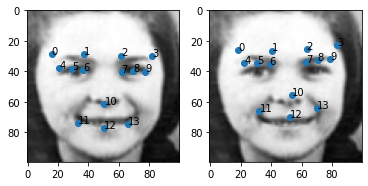

In [34]:
import pandas as pd
size = (100, 100, 1)
model1 = keras.models.load_model('try_model2.hdf5')
model2 = keras.models.load_model('final_model.hdf5')
df = pd.read_csv('test.csv')
ind = np.random.randint(len(df))
print(ind)
img = df.iloc[ind, 1]
img = list(map(int, img.split()))
img = np.array(img).reshape(96, 96)
img = resize(img, size, mode='constant')
#plt.imshow(img, cmap='gray')
img = img.astype('float32')
img = (img - np.mean(img)) / np.std(img)
y1 = model1.predict(img.reshape(1, 100, 100, 1))
y2 = model2.predict(img.reshape(1, 100, 100, 1))
xs1 = y1[0][::2]
ys1 = y1[0][1::2]
xs2 = y2[0][::2]
ys2 = y2[0][1::2]
plt.figure(figsize=(10, 10))
f, axarr = plt.subplots(1,2) 
axarr[0].imshow(img, cmap='gray')
axarr[1].imshow(img, cmap='gray')
axarr[0].scatter(xs1, ys1)
axarr[1].scatter(xs2, ys2)
for i in range(14):
    axarr[0].annotate(i, (xs1[i], ys1[i]))
    axarr[1].annotate(i, (xs2[i], ys2[i]))
plt.show()

In [6]:
for big_train_iteration in range(40):
    print("CUR ITER ", big_train_iteration+1)
    ex_train, ey_train = augmentation(x_train, y_train)
    ex_train, ey_train = filter_data(ex_train, ey_train)
    ex_val, ey_val = x_val, y_val
    ex_train = (ex_train - np.mean(ex_train)) / np.std(ex_train)
    ex_val = (ex_val - np.mean(ex_val)) / np.std(ex_val)
    print(ex_train.shape, ey_train.shape, ex_val.shape, ey_val.shape)
    print(np.mean(ex_train), np.std(ex_train), np.mean(ex_val), np.std(ex_val))
    reducelr = keras.callbacks.ReduceLROnPlateau(monitor = 'val_loss', factor = 0.5, patience = 5, verbose = 1)
    tfhistory = model.fit(ex_train.astype('float32'), ey_train.astype('float32'), batch_size=128, shuffle=True,
                      epochs=20, validation_data=(ex_val.astype('float32'), ey_val.astype('float32')),
                      callbacks=[reducelr])
    model.save('model_superfit_final.hdf5')
    model.save(f'model_superfit_final{big_train_iteration}.hdf5')

CUR ITER  1


NameError: name 'augmentation' is not defined

In [ ]:
def hist_plot(history):
    plt.plot(history.history['loss'][5:])
    plt.plot(history.history['val_loss'][5:])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.show()

In [ ]:
model.save('model_superfit.hdf5')

In [16]:
models = [keras.models.load_model(f'model_superfit_final{i}.hdf5') for i in tqdm(range(40))]
weights = [model.get_weights() for model in models]
new_weights = list()

for weights_list_tuple in tqdm(zip(*weights)):
    new_weights.append(
        [np.array(weights_).mean(axis=0)\
            for weights_ in zip(*weights_list_tuple)])
new_model = keras.models.Sequential()
new_model.set_weights(new_weights)

ResourceExhaustedError: OOM when allocating tensor with shape[3,3,256,256] and type float on /job:localhost/replica:0/task:0/device:GPU:0 by allocator GPU_0_bfc [Op:Mul]